In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm

# LOG_INTERVAL = 1

def generate_fourier_vectorized(L, n, N=10, kappa=0.25):
    """
    Generate a random track using Fourier series.
    Parameters:
    - L: int, the length of the track
    - n: int, the number of features
    - N: int, the number of harmonics for the Fourier series
    - kappa: float, the frequency factor for the Fourier series
    Returns: 
    - track: array-like, the track
    """
    x = np.linspace(0, 1, L)
    highest_frequency = int(N * kappa)
    frequencies = np.arange(1, highest_frequency+1)
    A = np.random.randn(n, highest_frequency)
    B = np.random.randn(n, highest_frequency)
    track = np.sum(A[:,:,None] * np.cos(2 * np.pi * frequencies[None, :, None] * x[None,None,:]) +
                   B[:,:,None] * np.sin(2 * np.pi * frequencies[None, :, None] * x[None,None,:]), axis=1)
    track += np.random.randn(n, 1)
    return track.T


def speed_vectorized(agent, track_features, alpha=1.0, beta=1.0):
    dot_product = np.einsum('ij,ij->i', agent, track_features)
    norm_agent = np.linalg.norm(agent, axis=1)
    norm_track = np.linalg.norm(track_features, axis=1)
    return alpha + beta * dot_product / (norm_agent * norm_track)

def rotate_features(agent, theta, u, v):
    """Rotates agent's features in the plane defined by vectors u and v."""
    I = np.identity(len(agent))
    rotation_matrix = (I + (np.cos(theta) - 1) * (np.outer(u, u) + np.outer(v, v)) +
                    np.sin(theta) * (np.outer(u, v) - np.outer(v, u)))
    return np.dot(rotation_matrix, agent)


def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                budget, agent_idx, min_improvement=0.05, rotation_scale=0.1, method = 'random'):    
    if budget > 0:
        # Initialize if not provided
        if last_best_lap_time[agent_idx] is None:
            last_best_lap_time[agent_idx] = float('inf')

        if lap_time <= last_best_lap_time[agent_idx]:
            # Update best-known state and lap time
            last_best_agent_state[agent_idx] = np.copy(agent)
            last_best_lap_time[agent_idx] = lap_time
        else:
            # Set to the best-known state if the current lap time is worse
            agent = np.copy(last_best_agent_state[agent_idx])

        # Generate random rotation angle and basis vectors
        theta = np.random.uniform(-rotation_scale, rotation_scale)

        if method == 'random':
            u, v = np.random.randn(len(agent)), np.random.randn(len(agent))
            u /= np.linalg.norm(u)
            v /= np.linalg.norm(v)

        elif method == 'orthogonal':
            u, v = generate_orthogonal_u_v(agent)
        
        elif method == 'max_feature':
            u, v = generate_u_v_from_max_feature(agent)
            
        elif method == 'top_k_features':
            u, v = generate_u_v_from_top_k_features(agent)
        
        
        

        # Rotate features
        agent = rotate_features(agent, theta, u, v)
        budget -= np.abs(theta)

    return agent, budget, last_best_lap_time[agent_idx], last_best_agent_state[agent_idx]

def generate_orthogonal_u_v(agent):
    """Generates two orthogonal vectors in the plane of the agent's features."""
    u = np.random.randn(len(agent))
    u /= np.linalg.norm(u)
    v = np.random.randn(len(agent))
    v -= np.dot(v, u) * u
    v /= np.linalg.norm(v)
    return u, v

def generate_u_v_from_max_feature(agent):
    """Generates two vectors in the plane of the agent's features, one pointing to the direction of the maximum absolute feature and the other orthogonal to it."""
    max_feature_idx = np.argmax(np.abs(agent))
    u = np.zeros(len(agent))
    u[max_feature_idx] = 1
    v = np.random.randn(len(agent))
    v -= np.dot(v, u) * u
    v /= np.linalg.norm(v)
    return u, v

def generate_u_v_from_top_k_features(agent, k=6, HALF_RANDOM = True):
    if HALF_RANDOM:
        """Generates two vectors in the plane of the agent's features, one pointing to the direction of the k maximum absolute features and the other orthogonal to it."""
        max_feature_idx = np.argsort(np.abs(agent))[-k:]
        u = np.zeros(len(agent))
        u[max_feature_idx] = 1
        u /= np.linalg.norm(u)
        
        v = np.random.randn(len(agent))
        v -= np.dot(v, u) * u
        v /= np.linalg.norm(v)
        return u, v
    else:
        """"Generates two vectors in the plane of the agent's features as a linear combination of the top 2*k features.
        """
        top_k_features_idx = np.argsort(np.abs(agent))[-2*k:]
        u = np.zeros(len(agent))
        v = np.zeros(len(agent))
        for i in top_k_features_idx[:k]:
            u[i] = 1
        for i in top_k_features_idx[k:]:
            v[i] = 1
        u /= np.linalg.norm(u)
        v /= np.linalg.norm(v)
        
        return u, v
 
# def generate_u_v_from_Bayesian_optimization

def old_main(num_agents=3, num_laps=10, initial_budget=1.0, live_plotting=True, pretrained_agents=None, track=None,
          colors = ['r','g','b','c'], methods = ['random', 'orthogonal', 'max_feature', 'top_k_features'],
          dt = 0.5, L = 30, n = 10):
    '''

    Main function to run the optimization simulation.
    
    Parameters:
    - num_agents: int, the number of agents to simulate
    - num_laps: int, the number of laps to simulate
    - initial_budget: float, the initial budget for each agent
    - live_plotting: bool, whether to plot the simulation live or not
    - pretrained_agents: list of arrays, the agents to use for the simulation
    - track: array-like, the track to simulate on
    - colors: list of str, the colors to use for plotting
    - methods: list of str, the optimization methods to use
    - dt: float, the time step for the simulation
    - L: int, the length of the track
    - n: int, the number of features for the track
    
    '''
    
    if track is None:
        track = generate_fourier_vectorized(L, n)
    else:
        track = np.array(track)

    lap_times_history = {method: np.zeros((num_laps, num_agents)) for method in methods}
    budget_history = {method: np.zeros((num_laps, num_agents)) for method in methods}

    for j, method in enumerate(methods):
        print(f"Method: {method}")
        
        if pretrained_agents is not None:
            num_agents = len(pretrained_agents)
            agents = np.array([np.array(agent) for agent in pretrained_agents])
        else:
            agents = np.array([np.random.randn(n) for _ in range(num_agents)])
        budgets = np.full(num_agents, initial_budget)
        
        # lap_times_history = np.zeros((num_laps, num_agents))
        # budget_history = np.zeros((num_laps, num_agents))
        
        last_best_agent_state = agents.copy()
        last_best_lap_time = np.full(num_agents, np.inf)
        
        if live_plotting:
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
            
            # Plot features
            for i in range(n):
                # title subplot
                ax1.set_title('Track Features')
                ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
            # ax1.legend()
            
            points = [ax1.plot([], [], 'o', lw=3, color=colors[j])[0] for i in range(num_agents)]
            circles = [ax2.plot([], [], 'o', lw=3, color=colors[j])[0] for i in range(num_agents)]
            ax2.set_title('Agent Positions')
            ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
            # as above but using generate_
        
        for lap in tqdm(range(num_laps)):
            positions = np.zeros(num_agents)
            lap_times = np.zeros(num_agents)
            
            while np.any(positions < L):
                s = np.floor(positions).astype(int) % L
                v = speed_vectorized(agents, track[s])
                positions += v * dt
                
                # Update lap_times only for agents still running
                mask = positions < L
                lap_times[mask] += dt
                
                if live_plotting:
                    for i in range(num_agents):
                        points[i].set_data(positions[i] % L, 0)
                        theta = 2 * np.pi * (positions[i] % L) / L
                        circles[i].set_data(np.cos(theta), np.sin(theta))

                    clear_output(wait=True)
                    display(fig)
                    plt.pause(0.01)
                    
            lap_times_history[method][lap, :] = lap_times
            budget_history[method][lap, :] = budgets
            
            ############################ OPTIMIZATION ###############################################################################
            for i in range(num_agents):
                agents[i], budgets[i], last_best_lap_time[i], last_best_agent_state[i] = optimize_agent(
                    agents[i], lap_times[i], last_best_lap_time,
                    last_best_agent_state, budgets[i], i, method = method)
                
            #########################################################################################################################
                
            
            if live_plotting:
                ax3.clear()
                ax4.clear()
                for i in range(num_agents):
                    ax3.plot(range(lap + 1), lap_times_history[method][:lap+1, i], label=f'Agent {i+1}', color=colors[j])
                    ax4.plot(range(lap + 1), budget_history[method][:lap+1, i], label=f'Agent {i+1}', color=colors[j])
                # ax3.legend()
                # ax4.legend()
                ax3.set_title('Lap Times Progression')
                ax4.set_title('Budget Progression')
                ax3.set_xlabel('Lap')
                ax4.set_xlabel('Lap')
                ax3.set_ylabel('Lap Time')
                ax4.set_ylabel('Remaining Budget')
        
        if not live_plotting:
            # Plot the lap times history and budget history only at the end
            fig, axs = plt.subplots(1, 2, figsize=(16, 6))
            for i in range(num_agents):
                axs[0].plot(range(num_laps), lap_times_history[method][:, i], label=f'Agent {i+1}', color=colors[j])
                axs[1].plot(range(num_laps), budget_history[method][:, i], label=f'Agent {i+1}', color=colors[j])
            # axs[0].legend()
            # axs[1].legend()
            axs[0].set_title('Lap Times Progression')
            axs[1].set_title('Budget Progression')
            axs[0].set_xlabel('Lap')
            axs[1].set_xlabel('Lap')
            axs[0].set_ylabel('Lap Time')
            axs[1].set_ylabel('Remaining Budget')
            plt.show()

        
    return lap_times_history, budget_history, agents, track




In [11]:
L = 30
N_FEATURES = 10
N_LAPS = 500
N_AGENTS = 40
track = generate_fourier_vectorized(L, N_FEATURES)

Method: orthogonal


100%|██████████| 500/500 [00:04<00:00, 122.28it/s]


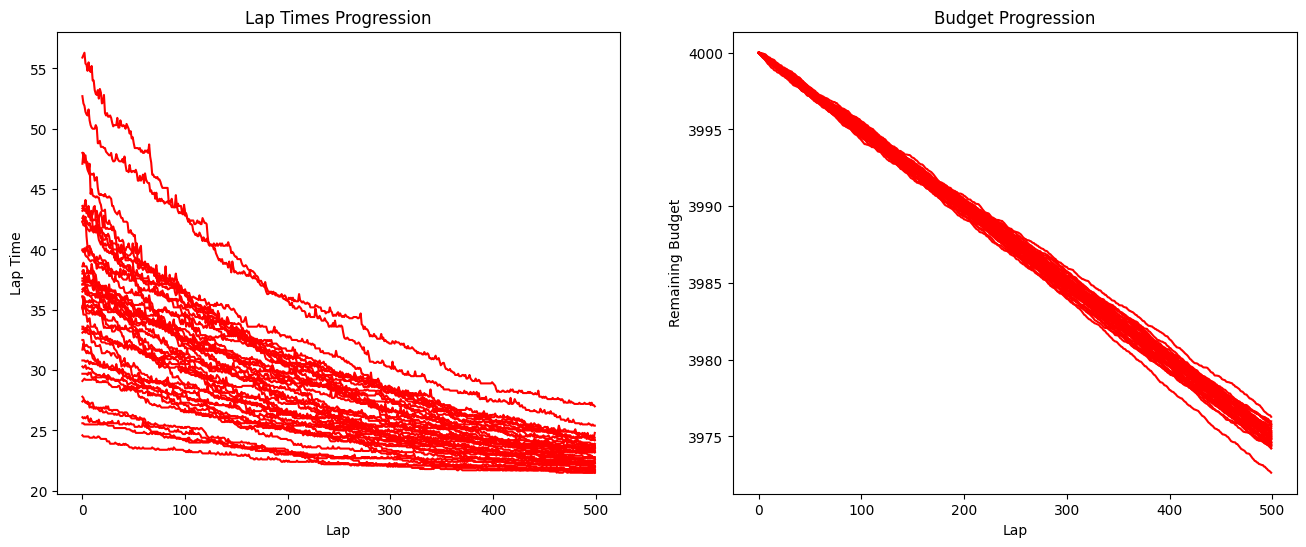

Method: max_feature


100%|██████████| 500/500 [00:03<00:00, 146.65it/s]


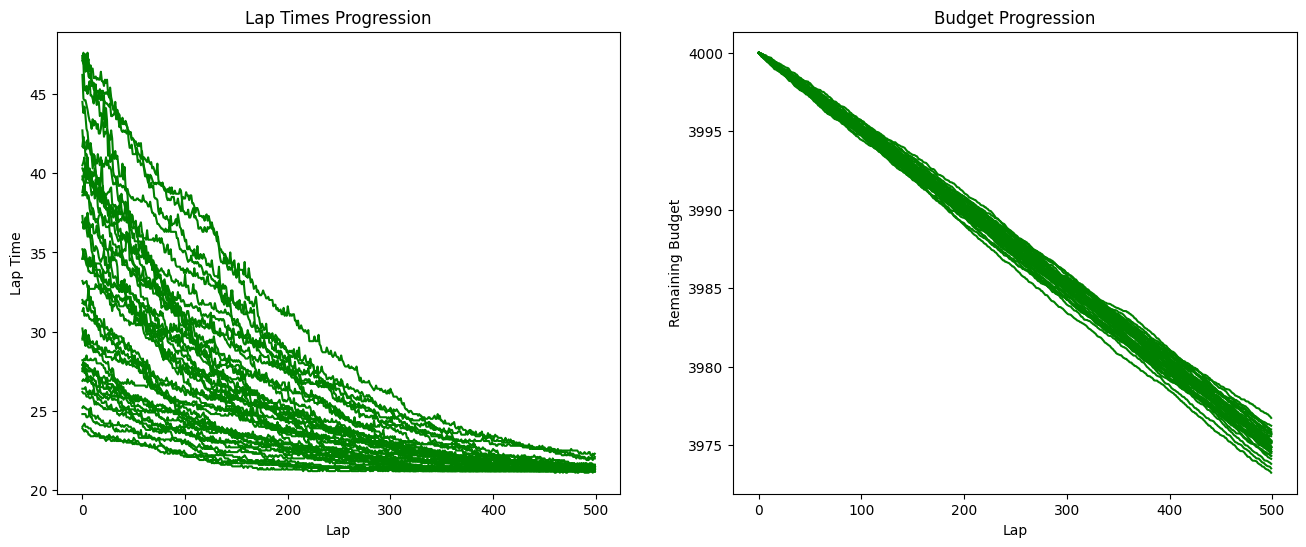

Method: top_k_features


100%|██████████| 500/500 [00:03<00:00, 134.78it/s]


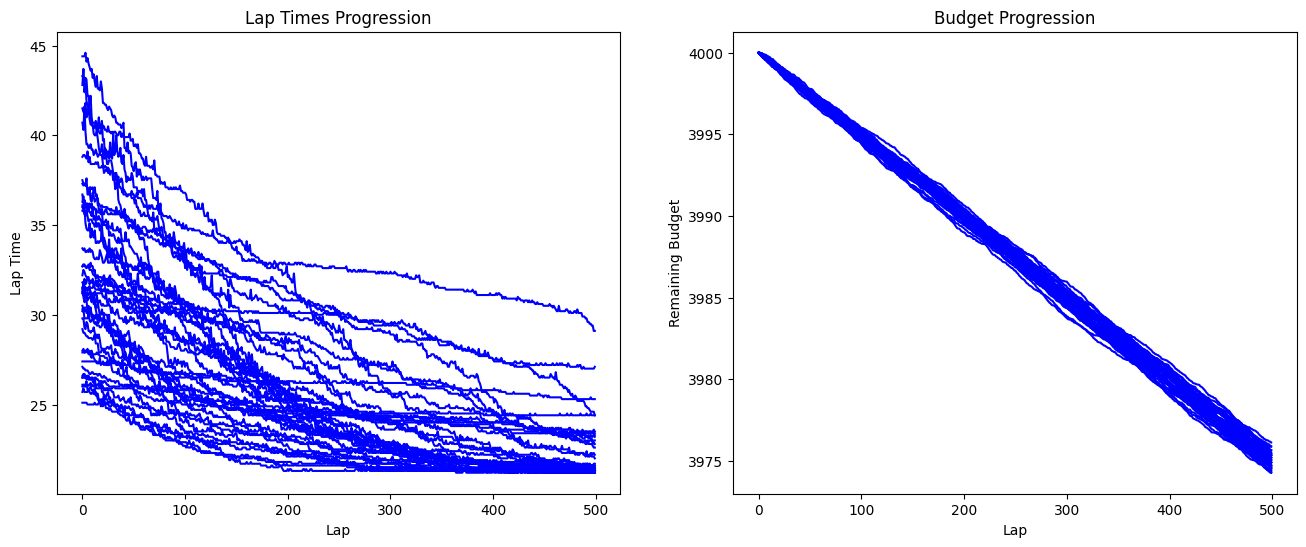

In [12]:



lap_times_history, budget_history, trained_agents, track = old_main(num_agents=N_AGENTS, num_laps=N_LAPS, initial_budget=4000.0, live_plotting=False, dt=0.1, L = L, n = N_FEATURES, track=track, methods = ['orthogonal', 'max_feature', 'top_k_features'])


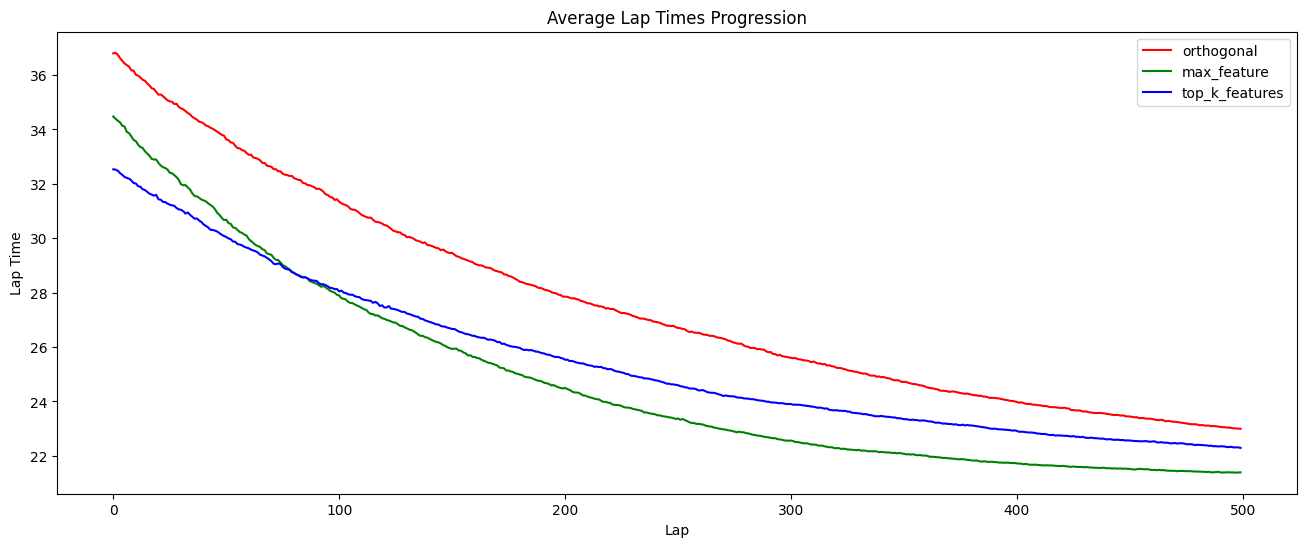

In [13]:
colors = ['r','g','b','c']
# plot average lap times history for each method
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for j, method in enumerate(lap_times_history):
    ax.plot(range(N_LAPS), np.mean(lap_times_history[method], axis=1), label=f'{method}', color=colors[j])
ax.legend()
ax.set_title('Average Lap Times Progression')
ax.set_xlabel('Lap')
ax.set_ylabel('Lap Time')
plt.show()
    

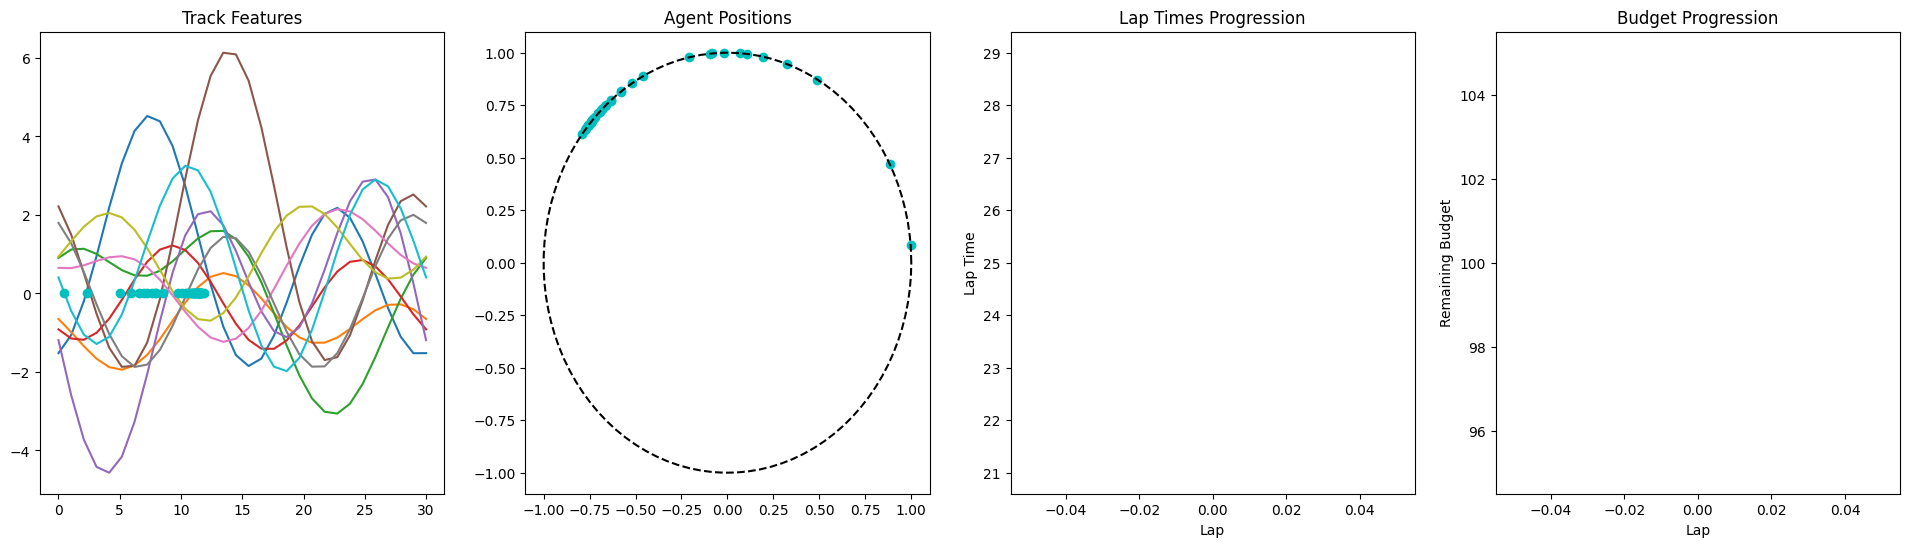

100%|██████████| 2/2 [00:30<00:00, 15.47s/it]


({'random': array([[22. , 21.5, 21. , 21. , 21. , 21. , 29. , 21.5, 23. , 21. , 25. ,
          21.5, 21. , 22.5, 21.5, 21. , 21.5, 21. , 23.5, 24. , 24. , 23. ,
          21. , 22.5, 27. , 21. , 23. , 21. , 21.5, 21. , 21.5, 21. , 21. ,
          21. , 21. , 21.5, 22.5, 21. , 21. , 21. ],
         [22. , 21.5, 21. , 21. , 21. , 21. , 29. , 21.5, 23. , 21. , 25. ,
          21.5, 21. , 22.5, 21.5, 21. , 21.5, 21. , 23.5, 24. , 24. , 23. ,
          21. , 22.5, 27. , 21. , 23. , 21. , 21.5, 21. , 21.5, 21. , 21. ,
          21. , 21. , 21.5, 22.5, 21. , 21. , 21. ]]),
  'orthogonal': array([[22. , 21.5, 21. , 21. , 21. , 21. , 29. , 21.5, 23. , 21. , 25. ,
          21.5, 21. , 22.5, 21.5, 21. , 21.5, 21. , 23.5, 24. , 24. , 23. ,
          21. , 22.5, 27. , 21. , 23. , 21. , 21.5, 21. , 21.5, 21. , 21. ,
          21. , 21. , 21.5, 22.5, 21. , 21. , 21. ],
         [22. , 21.5, 21. , 21. , 21. , 21. , 29. , 21.5, 23. , 21. , 25. ,
          21.5, 21. , 22.5, 21.5, 21. , 21.5, 21. , 23.

In [15]:
old_main(num_agents=N_AGENTS, num_laps=2, initial_budget=100.0, live_plotting=True, pretrained_agents=trained_agents, track=track, dt=0.5, L = L, n = N_FEATURES)

In [39]:
# To do:
    # Fix inefficiency in optimization loop:
        # FIXED - The agent should not be reverted to the best known state if there is no improvement, instead it should be rotated again from the best-known state -- FIXED
    # - Add agent interaction:
        # - A following agent should be slowed down by the agent in front of it to mimic real life

In [56]:
class Agent():
    def __init__(self, n_features, budget = 40000):
        self.features = np.random.randn(n_features)
        self.budget = budget
        self.best_known_state = np.copy(self.features)
        self.best_lap_time = float('inf')
        self.last_u_v = None
        self.last_theta = None
        self.best_u_v = None
        self.best_theta = None
        self.lap_times_history = []
        self.budget_history = []
        self.improvements_history = []
        
    def optimize(self, lap_time, rotation_scale = 0.1, method = 'max_feature', MEMORY = True, FIXED_ROTATION_SCALE = False):
        self.lap_times_history.append(lap_time)
        self.budget_history.append(self.budget)
        self.improvements_history.append(self.best_lap_time - lap_time)

        if self.budget > 0:
            
            if lap_time <= self.best_lap_time:
                # Update best-known state, lap time and rotation
                self.best_known_state = np.copy(self.features)                
                self.best_lap_time = lap_time
                self.best_u_v = self.last_u_v
                self.best_theta = self.last_theta
            else:
                # Set to the best-known state if the current lap time is worse
                self.features = np.copy(self.best_known_state)
                self.best_u_v = None
                self.best_theta = None

            # Reset best-known rotation parameters if improvements are plateauing
            self.characterize_improvements_history()
            
            # Use random rotation if no best-known rotation
            if self.best_u_v is None or MEMORY == False: 
                
                if FIXED_ROTATION_SCALE:
                    sign = np.random.choice([-1.0, 1.0])
                    theta = sign * rotation_scale
                else:
                    # Generate random rotation angle and basis vectors
                    theta = np.random.uniform(-rotation_scale, rotation_scale)

                if method == 'random':
                    u, v = np.random.randn(len(self.features)), np.random.randn(len(self.features))
                    u /= np.linalg.norm(u)
                    v /= np.linalg.norm(v)
                elif method == 'orthogonal':
                    u, v = generate_orthogonal_u_v(self.features)
                elif method == 'max_feature':
                    u, v = generate_u_v_from_max_feature(self.features)
                elif method == 'top_k_features':
                    u, v = generate_u_v_from_top_k_features(self.features)                

            # Use the best-known rotation
            else: 
                u, v = self.best_u_v
                theta = self.best_theta

            # Rotate features
            self.features = rotate_features(self.features, theta, u, v)
            self.budget -= np.abs(theta)
            self.last_u_v = u, v
            self.last_theta = theta
            
        else:
            print('Budget is over, resetting agent...')
            self.budget = 40000

    def characterize_improvements_history(self):
        IMPROVEMENT_LOOKBACK = 5
        IMPROVEMENT_THRESHOLD = 0.01  # Threshold for considering improvements as plateauing
        
        # Ensure we have enough data to analyze
        if len(self.improvements_history) >= IMPROVEMENT_LOOKBACK:
            recent_improvements = self.improvements_history[-IMPROVEMENT_LOOKBACK:]
            avg_improvement = sum(recent_improvements) / IMPROVEMENT_LOOKBACK
            
            if avg_improvement < IMPROVEMENT_THRESHOLD:
                # If the average improvement is below the threshold, consider it as plateauing
                self.best_u_v = None
                self.best_theta = None

        # return self.features, self.budget, self.best_lap_time, self.best_known_state

In [57]:
# new main function that uses the Agent class

def main(n_agents, track, n_laps, dt = 0.1, L = 30, N_FEATURES = 10, method = 'max_feature', rotation_scale = 0.1, MEMORY = True, FIXED_ROTATION_SCALE = True):
    

    agents = [Agent(N_FEATURES) for _ in range(n_agents)]

    if track.any() == None:
        track = generate_fourier_vectorized(L, N_FEATURES)
    else:
        track = np.array(track)
    for lap in tqdm(range(n_laps)):
        positions = np.zeros(len(agents))
        lap_times = np.zeros(len(agents))
        while np.any(positions < L):
            s = np.floor(positions).astype(int) % L
            agents_features = np.array([agent.features for agent in agents])
            v = speed_vectorized(agents_features, track[s])
            positions += v * dt
            # Update lap_times only for agents still running
            mask = positions < L
            lap_times[mask] += dt
        for i, agent in enumerate(agents):
            agent.optimize(lap_times[i], rotation_scale = rotation_scale, method = method, MEMORY = MEMORY, FIXED_ROTATION_SCALE = FIXED_ROTATION_SCALE)
    return agents, track



In [60]:
L = 30
N_FEATURES = 500
N_LAPS = 4500
N_AGENTS = 25
DT = 0.1
ROTATION_SCALE = 0.5
FIXED_ROTATION_SCALE = False

track = generate_fourier_vectorized(L, N_FEATURES)
# track = np.array(track)

  0%|          | 0/4500 [00:00<?, ?it/s]

100%|██████████| 4500/4500 [21:05<00:00,  3.56it/s]


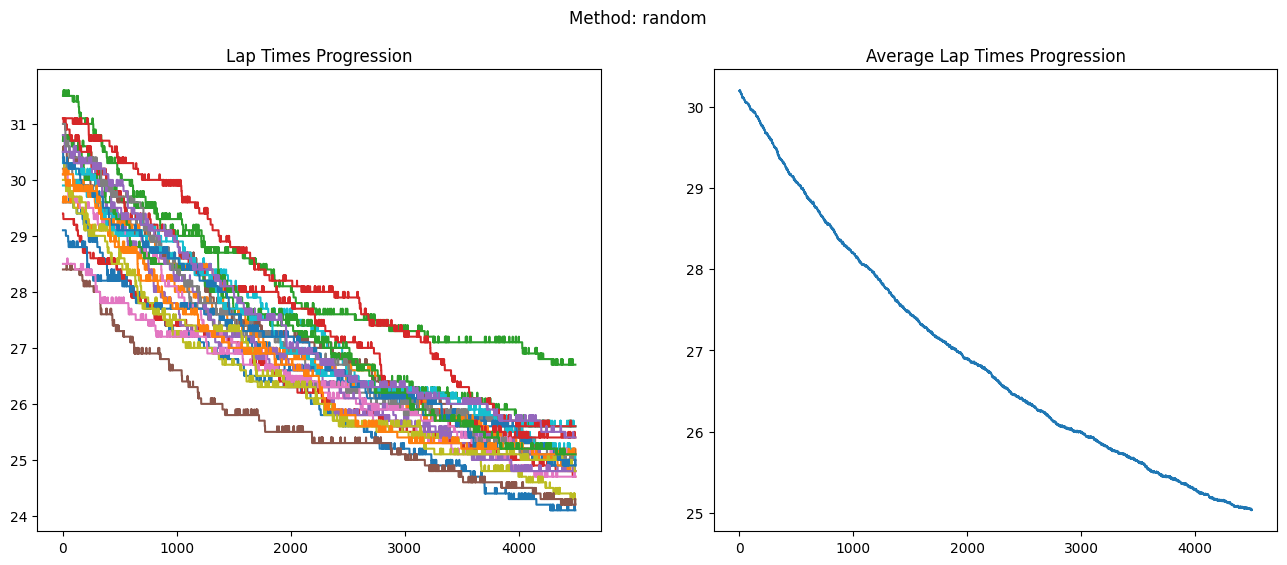

100%|██████████| 4500/4500 [09:48<00:00,  7.64it/s]


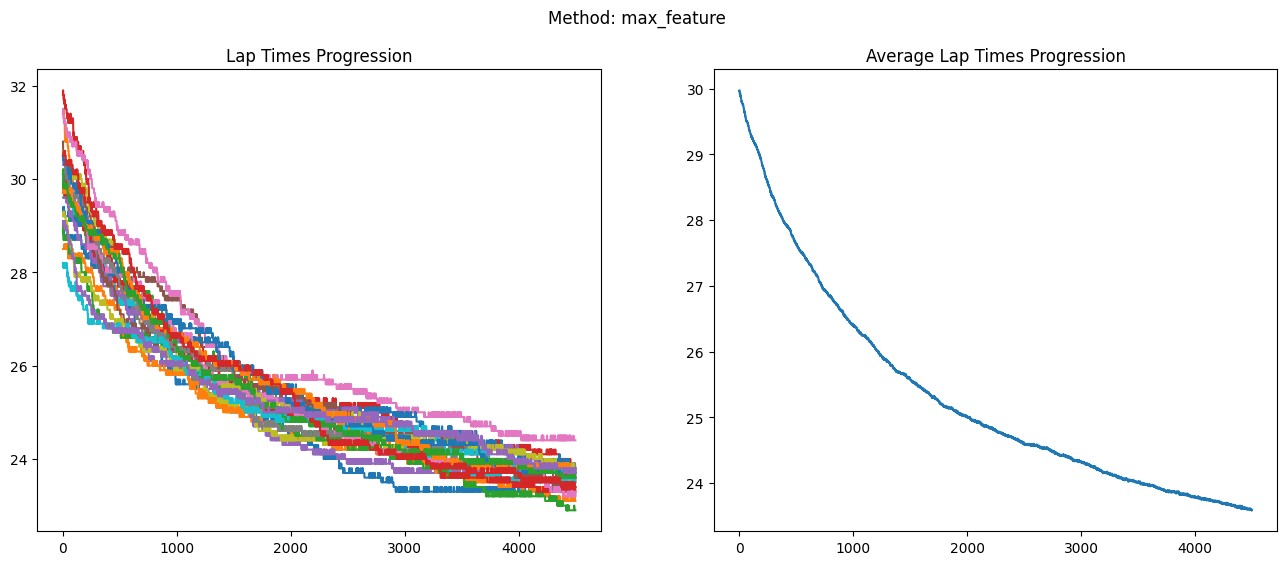

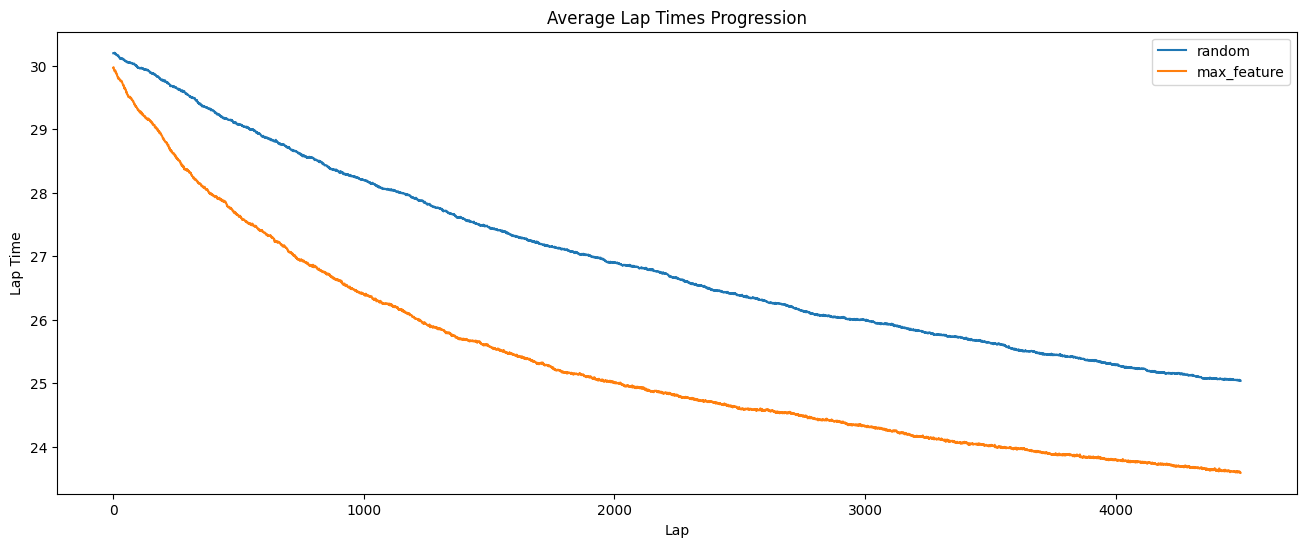

In [61]:
methods = ['random', 'max_feature'] #, 'top_k_features']
MEMORY = True
aggregate_lap_times = {method: [] for method in methods}
for method in methods:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Method: {method}')
    
    agents, track = main(n_agents= N_AGENTS, track = track, n_laps = N_LAPS, method = method, MEMORY = MEMORY, L = L, N_FEATURES = N_FEATURES, dt = DT, rotation_scale = ROTATION_SCALE, FIXED_ROTATION_SCALE = FIXED_ROTATION_SCALE)
    
    for agent in agents:
        ax1.plot(agent.lap_times_history)
    # ax 1 title
    ax1.set_title('Lap Times Progression')
    

    # plot average lap times history for each method
    avg_lap_times = [agent.lap_times_history for agent in agents]
    aggregate_lap_times[method] = np.mean(avg_lap_times, axis = 0)
    ax2.plot(np.mean(avg_lap_times, axis = 0))
    # ax 2 title
    ax2.set_title('Average Lap Times Progression')
    plt.show()
    
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for method in methods:
    ax.plot(aggregate_lap_times[method], label = method)
ax.legend()
ax.set_title('Average Lap Times Progression')
ax.set_xlabel('Lap')
ax.set_ylabel('Lap Time')
plt.show()






100%|██████████| 500/500 [00:02<00:00, 176.16it/s]


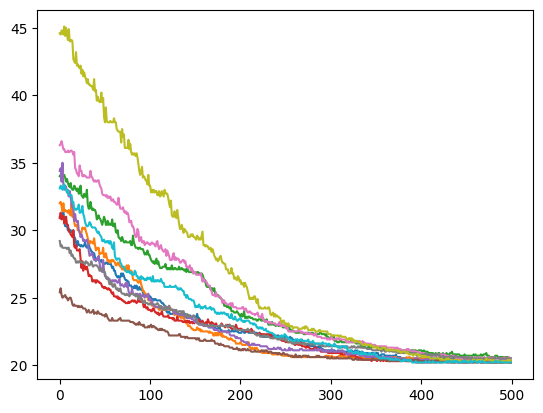

In [39]:
# Memoryless
agents, track = main(n_agents= 10, track = track, n_laps = 500, MEMORY=False)
# print lap times history for each agent
for agent in agents:
    plt.plot(agent.lap_times_history)

In [ ]:
# To do:
# Collective learning: add option to use the best-known state between all agents as a starting point for the next lap
# Non-naive rotation selection: use Bayesian optimization to select the best rotation parameters